In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv("./tmp/INSEE_deces_1990_2019_byweek.csv.gz", compression='gzip')

In [3]:
df.head()

,year,weeknumber,age_bin,sexe,departement,region,nb_deces
0,1990,1,00 à 19 ans,1,Ain,Auvergne-Rhône-Alpes,1.0
1,1990,1,00 à 19 ans,1,Aisne,Hauts-de-France,0.0
2,1990,1,00 à 19 ans,1,Allier,Auvergne-Rhône-Alpes,0.0
3,1990,1,00 à 19 ans,1,Alpes-Maritimes,Provence-Alpes-Côte d'Azur,1.0
4,1990,1,00 à 19 ans,1,Alpes-de-Haute-Provence,Provence-Alpes-Côte d'Azur,3.0


# First exploration of the data

Groupby to get data at the national level, mix also age_bin and sexe

In [4]:
# Weeknumber 1, 52, 53 are noisy (with sudden drops in numbers)
# I guess because some years border weeknumbers are cut in half, etc). 
# I do not see any simple solution to this so I'll remove the weird weeknumbers; 1, 52 and 53
df = df[(df.weeknumber>1) & (df.weeknumber<52)] 

In [5]:
df_nat = df.groupby(["year","weeknumber"], as_index=False)["nb_deces"].sum()

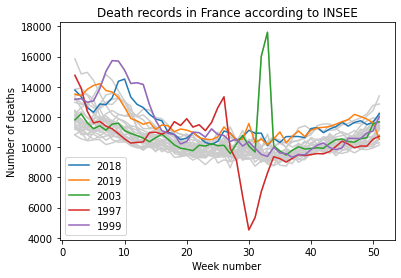

In [6]:
ax = plt.subplot(1,1,1)
for y in np.arange(1990,2018):
    ax.plot(df_nat.weeknumber[df_nat.year==y], df_nat.nb_deces[df_nat.year==y].astype('float'), '-', color="0.8");
p2, = ax.plot(df_nat.weeknumber[df_nat.year==2018], df_nat.nb_deces[df_nat.year==2018].astype('float'), '-', label="2018");
p3, = ax.plot(df_nat.weeknumber[df_nat.year==2019], df_nat.nb_deces[df_nat.year==2019].astype('float'), '-', label="2019");
p4, = ax.plot(df_nat.weeknumber[df_nat.year==2003], df_nat.nb_deces[df_nat.year==2003].astype('float'), '-', label="2003");
p4, = ax.plot(df_nat.weeknumber[df_nat.year==1997], df_nat.nb_deces[df_nat.year==1997].astype('float'), '-', label="1997");
p4, = ax.plot(df_nat.weeknumber[df_nat.year==1999], df_nat.nb_deces[df_nat.year==1999].astype('float'), '-', label="1999");
ax.legend()
plt.title("Death records in France according to INSEE")
plt.xlabel("Week number")
plt.ylabel("Number of deaths")
plt.show()

Observations:
- 2003 heat wave in France was bad... (so much that we will ignore it, too special)
- It seems that the worst flu in the data was in 1999: quite a bad one
- 1997 will be considered bogus and should be removed from further analysis (if someone knows what happened please tell me)

In [7]:
df = df[ (df['year']!=2003) & (df['year']!=1997)  ]
df_nat = df.groupby(["year","weeknumber"], as_index=False)["nb_deces"].sum()

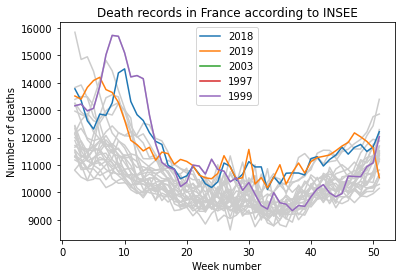

In [8]:
ax = plt.subplot(1,1,1)
for y in np.arange(1990,2018):
    ax.plot(df_nat.weeknumber[df_nat.year==y], df_nat.nb_deces[df_nat.year==y].astype('float'), '-', color="0.8");
p2, = ax.plot(df_nat.weeknumber[df_nat.year==2018], df_nat.nb_deces[df_nat.year==2018].astype('float'), '-', label="2018");
p3, = ax.plot(df_nat.weeknumber[df_nat.year==2019], df_nat.nb_deces[df_nat.year==2019].astype('float'), '-', label="2019");
p4, = ax.plot(df_nat.weeknumber[df_nat.year==2003], df_nat.nb_deces[df_nat.year==2003].astype('float'), '-', label="2003");
p4, = ax.plot(df_nat.weeknumber[df_nat.year==1997], df_nat.nb_deces[df_nat.year==1997].astype('float'), '-', label="1997");
p4, = ax.plot(df_nat.weeknumber[df_nat.year==1999], df_nat.nb_deces[df_nat.year==1999].astype('float'), '-', label="1999");
ax.legend()
plt.title("Death records in France according to INSEE")
plt.xlabel("Week number")
plt.ylabel("Number of deaths")
plt.show()

Now we have a good dataset to investigate quantitatively how bad is a flu.

To start I will create a very basic index `index_bad_flu` which will simply take the number of deaths during the first weeks of the year as the numerator, and the number in the middle of the year as the denominator. This will roughly index how bad the flu has been each year.

In [9]:
index_bad_flu = dict()
for year in np.unique(df['year']):
    death_during_flu_season = np.sum( df['nb_deces'][(df['year']==year) & (df['weeknumber']>1) & (df['weeknumber']<=15)] )
    death_during_summer = np.sum( df['nb_deces'][(df['year']==year) & (df['weeknumber']>21) & (df['weeknumber']<=35)] )
    index_bad_flu[year] = death_during_flu_season / death_during_summer
index_bad_flu = pd.DataFrame.from_dict(index_bad_flu, orient='index', columns=['index_bad_flu'])
index_bad_flu.reset_index(level=0, inplace=True)
index_bad_flu.columns=['year', 'index_bad_flu']
index_bad_flu

,year,index_bad_flu
0,1990,1.147278
1,1991,1.140609
2,1992,1.154309
3,1993,1.148447
4,1994,1.086701
5,1995,1.089051
6,1996,1.199754
7,1998,1.210550
8,1999,1.352213
9,2000,1.202763


In [10]:
# Save this table
index_bad_flu.to_csv("./preprocessed_data/index_bad_flu.csv", index=False)

In [11]:
# Add this variable to the dataset
df = df.join(index_bad_flu.set_index('year'), on='year') 

In [12]:
df

,year,weeknumber,age_bin,sexe,departement,region,nb_deces,index_bad_flu
1010,1990,2,00 à 19 ans,1,Ain,Auvergne-Rhône-Alpes,0.0,1.147278
1011,1990,2,00 à 19 ans,1,Aisne,Hauts-de-France,2.0,1.147278
1012,1990,2,00 à 19 ans,1,Allier,Auvergne-Rhône-Alpes,0.0,1.147278
1013,1990,2,00 à 19 ans,1,Alpes-Maritimes,Provence-Alpes-Côte d'Azur,2.0,1.147278
1014,1990,2,00 à 19 ans,1,Alpes-de-Haute-Provence,Provence-Alpes-Côte d'Azur,0.0,1.147278
...,...,...,...,...,...,...,...,...
1584055,2019,51,75 ans et plus,2,Vendée,Pays de la Loire,51.0,1.204226
1584056,2019,51,75 ans et plus,2,Vienne,Nouvelle-Aquitaine,34.0,1.204226
1584057,2019,51,75 ans et plus,2,Vosges,Grand Est,37.0,1.204226
1584058,2019,51,75 ans et plus,2,Yonne,Bourgogne-Franche-Comté,26.0,1.204226


In [13]:
df_ohe = df

# One hot encoding of categorical variables
df_ohe = pd.concat([df_ohe,pd.get_dummies(df_ohe['age_bin'], prefix='age_bin')],axis=1)
df_ohe.drop(['age_bin'],axis=1, inplace=True) # now drop the original column

df_ohe = pd.concat([df_ohe,pd.get_dummies(df_ohe['departement'], prefix='departement')],axis=1)
df_ohe.drop(['departement'],axis=1, inplace=True) # now drop the original column

df_ohe = pd.concat([df_ohe,pd.get_dummies(df_ohe['region'], prefix='region')],axis=1)
df_ohe.drop(['region'],axis=1, inplace=True) # now drop the original column

In [14]:
df_ohe.head()

,year,weeknumber,sexe,nb_deces,index_bad_flu,age_bin_00 à 19 ans,age_bin_20 à 39 ans,age_bin_40 à 59 ans,age_bin_60 à 74 ans,age_bin_75 ans et plus,...,region_Hauts-de-France,region_La Réunion,region_Martinique,region_Mayotte,region_Normandie,region_Nouvelle-Aquitaine,region_Occitanie,region_Pays de la Loire,region_Provence-Alpes-Côte d'Azur,region_Île-de-France
1010,1990,2,1,0.0,1.147278,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1011,1990,2,1,2.0,1.147278,1,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
1012,1990,2,1,0.0,1.147278,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1013,1990,2,1,2.0,1.147278,1,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1014,1990,2,1,0.0,1.147278,1,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


In [15]:
df_train = df_ohe[df_ohe.year<2018]
df_val = df_ohe[df_ohe.year==2018]
y_train = df_train.pop('nb_deces')
y_val = df_val.pop('nb_deces')
del df_ohe

In [16]:
print(df_train.shape)
print(df_val.shape)

(1312460, 128)
(50500, 128)


In [17]:
#from sklearn.linear_model import LinearRegression
#from sklearn.linear_model import LogisticRegression
from sklearn import svm

Here we keep the actual index_bad_flu of the year 2018, which is cheating since this is the future.
To keep the approach we will use for 2020, we'll get lower and upper boundaries on the 2018 predictions by using other index_bad_flu values (the min and max historicaly).

In [ ]:
#reg = LogisticRegression().fit(df_train, y_train)
clf = svm.SVR()
clf.fit(df_train, y_train, verbose=True)

In [ ]:
y_predict = clf.predict(df_val)

In [ ]:
# Reinitialize df_val without the one-hot encoding
df_val = df[df.year==2018]

In [ ]:
# Add the y_predict to the dataframe
df_val['y_predict'] = y_predict

In [ ]:
# Do the usual groupby to visualize the predictions once aggregated nationaly
df_val_nat = df_val.groupby(["year","weeknumber"], as_index=False)[["nb_deces", "y_predict"]].sum()

In [ ]:
ax = plt.subplot(1,1,1)
p1, = ax.plot(df_val_nat.weeknumber, df_val_nat.nb_deces, '-', label="Observed");
p2, = ax.plot(df_val_nat.weeknumber, df_val_nat.y_predict, '-', label="Predicted");
ax.legend()
plt.title("Death records prediction on year 2018")
plt.xlabel("Week number")
plt.ylabel("Number of deaths")
plt.show()